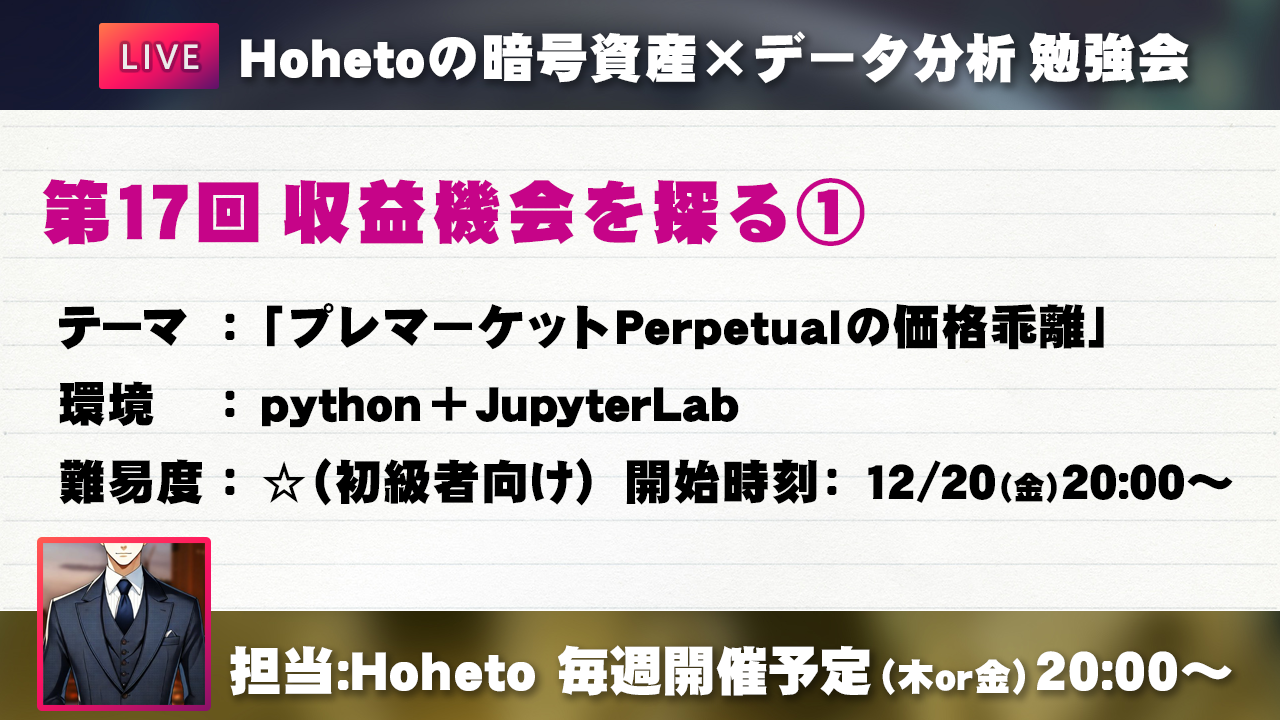

In [7]:
from IPython.display import Image

Image('./images/17_00.png')

# Hoheto勉強会 第17回 収益機会を探る①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- 収益機会に繋がりそうな、マーケットや価格乖離について調べます。
- 今回は目立って乖離しているbybitのHYPEUSDTのプレマーケットPerpetualに焦点を当てます。

# bybitのHYPEUSDTの価格乖離

## bybitには既にHYPEが上場している？

- https://www.bybit.com/trade/usdt/HYPEUSDT
- これは「プレマーケットPerpetual」という商品。どういうものか？
  - プレマーケット・ペルペチュアルとは何ですか？( https://www.bybit.com/en/help-center/article/FAQ-Pre-Market-Perpetual )
  - 将来のPerpetual（無期限先物）のために設定されたプレマーケット。Perpetualの公式リリース前に取引できる。
  - 実際のPerpetualが上場すると、このPerpetual契約のポジションに変換される。
  - 最初のマッチング時には板寄せがある（ここで決まった価格は正式な価格と異なる可能性あり）。それ以降は通常のPerpetual同様に取引できる。
  - 板寄せ以降の手数料はMaker 4bp、Taker 10bp（VIPレベルで変動）
  - レバレッジは最大5倍。最大ポジション25万ドルまで。値幅制限上下5%。
  - <font color="red">インデックス価格が適切に取得できない場合、この契約自体の売買注文価格が使用される（つまり虚無）。</font>
  - <font color="red">この場合、Funding Rateは、0.01%固定される。</font>


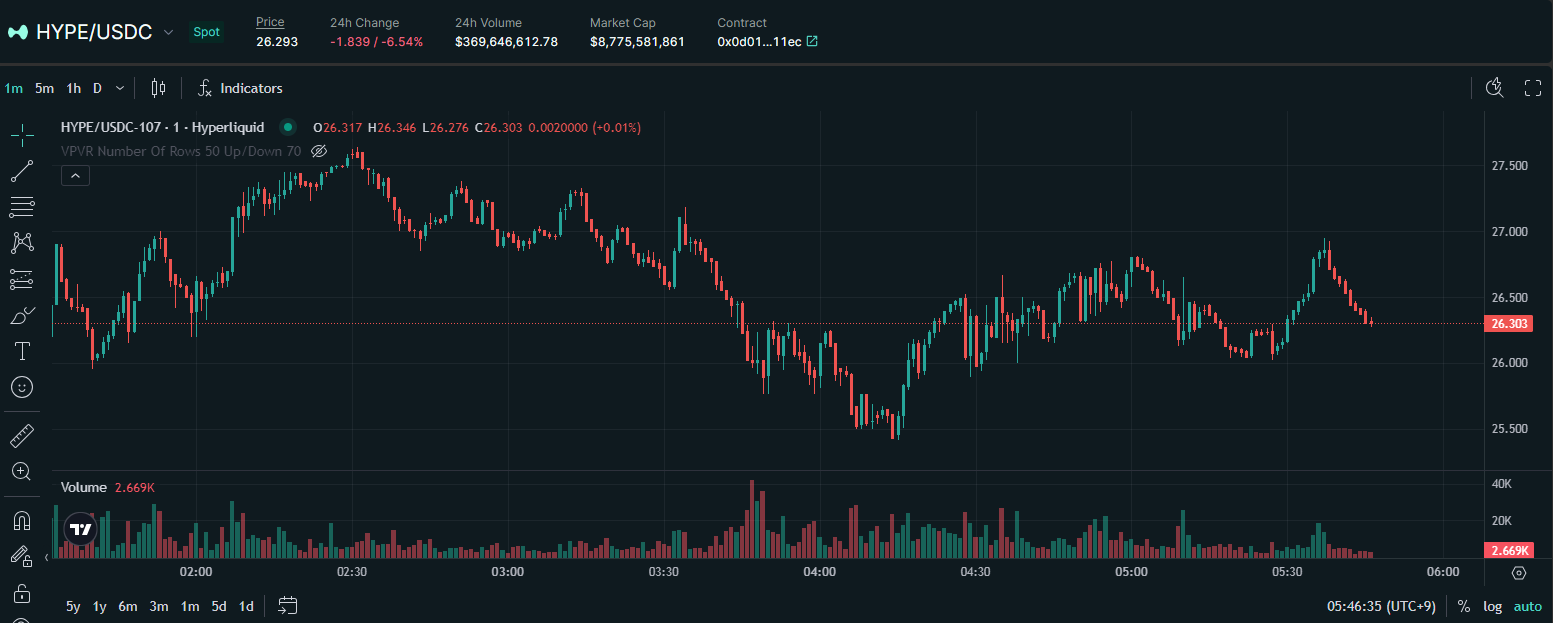

In [17]:
# 12/18 6:00時点　HiperliquidでのHYPE/USDC現物 約26.3ドル
Image('./images/17_02.png', width=1000)

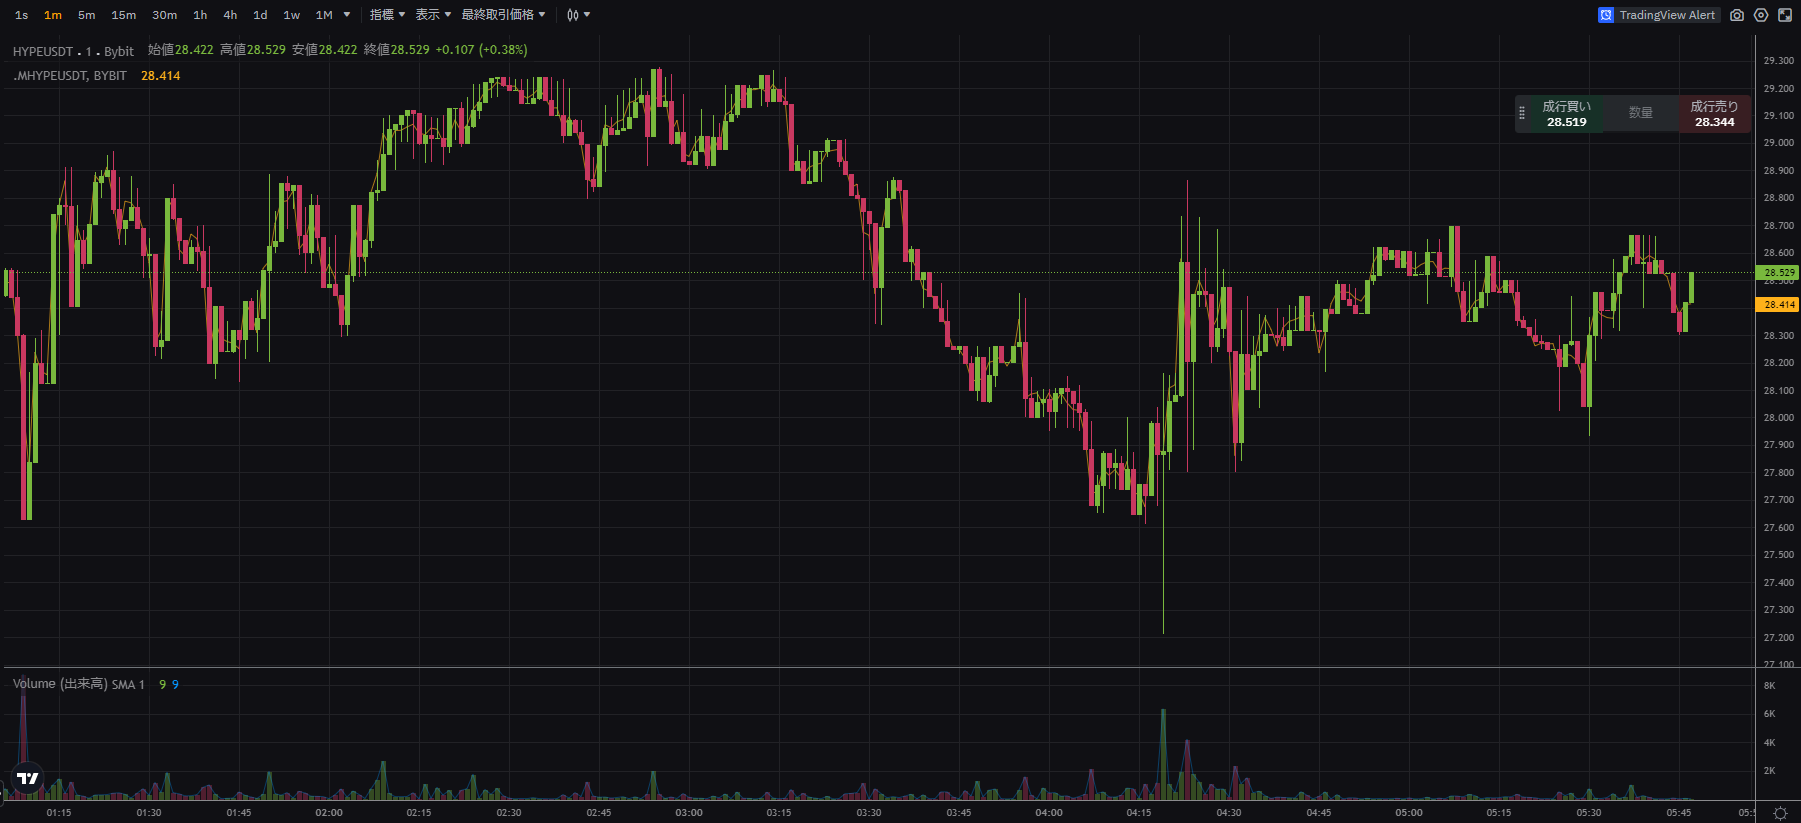

In [19]:
# 12/18 6:00時点　bybit プレマーケットPerpetualでのHYPE/USDT:USDT 約28.5ドル
Image('./images/17_03.png', width=1000)

- 約8%ほどbybitのほうが高い。
- このように恒常的に乖離が開いているのは、Funding Rateの仕組みが働いていないからと考えられる。
- 出来高は12/18時点で約2200万ドル / 24h。そこそこある。
- HyperLiquidにアクセスできない層に対して、一定の需要があると思われる。

- 収益機会として、
  - 雑な成行が結構あるのでは？（1分足でヒゲが結構出ている）
  - 実際のHYPE価格と乖離しても買う・売る人がいるのでは？
  - このままPerpetual取引が始まったら乖離はどうなる？

# いつもの環境設定

In [8]:
%load_ext autoreload
%autoreload 2

In [144]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import time
import warnings
from datetime import datetime, timezone
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [10]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

In [11]:
apis = {
    'bybit': ccxt.bybit(),
    'hyperliquid': ccxt.hyperliquid(),
}

In [79]:
from dateutil import parser

def convert_time_string_to_seconds(time_str: str) -> int:
    unit = time_str[-1]
    value = int(time_str[:-1])
    if unit == 'm':
        return value * 60
    elif unit == 'h':
        return value * 3600
    elif unit == 'd':
        return value * 86400
    else:
        raise ValueError()

def fetch_ohlcv(exchange, symbol, from_date, to_date, timeframe):
    timeframe_sec = convert_time_string_to_seconds(timeframe)
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    start_time = from_time
    limit = 1000
    ohlcv_list = []
    while True:
        end_time = int(start_time + limit * timeframe_sec * 1000)
        if type(exchange) == str:
            api = apis[exchange]
        else:
            api = exchange
        ohlcv = api.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time, limit=limit)
        if len(ohlcv) == 0:
            break
        ohlcv_list += ohlcv
        start_time = ohlcv[-1][0] + 1
        if start_time > to_time:
            break
        time.sleep(1)
    df = pd.DataFrame(ohlcv_list)
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df['ror'] = (df['close'] - df['open']) / df['open']
    df.columns = [f'{exchange}_{column}' for column in df.columns]
    return df


In [80]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

# データ取得

## bybit

- bybitは12/5から取得可能（ここがプレマーケット開始日）

In [81]:
ohlcv_bybit = fetch_ohlcv('bybit', 'HYPE/USDT:USDT', from_date='2024-11-01', to_date='2024-12-18', timeframe='1m')
ohlcv_bybit

,bybit_open,bybit_high,bybit_low,bybit_close,bybit_volume,bybit_ror
timestamp,,,,,,
2024-12-05 12:55:00+00:00,13.800,13.800,13.800,13.800,19764.54,0.000000
2024-12-05 12:56:00+00:00,13.800,13.800,13.800,13.800,0.00,0.000000
2024-12-05 12:57:00+00:00,13.800,13.800,13.800,13.800,0.00,0.000000
2024-12-05 12:58:00+00:00,13.800,13.800,13.800,13.800,0.00,0.000000
2024-12-05 12:59:00+00:00,13.800,13.800,13.800,13.800,0.00,0.000000
...,...,...,...,...,...,...
2024-12-18 00:29:00+00:00,28.140,28.141,28.051,28.084,147.04,-0.001990
2024-12-18 00:30:00+00:00,28.084,28.250,28.000,28.188,457.21,0.003703
2024-12-18 00:31:00+00:00,28.188,28.197,28.000,28.055,926.32,-0.004718


## HyperLiquid

- hyperliquidは、直近5000本しか取れないかも（仕様未確認）

In [86]:
ohlcv_hl_spot = fetch_ohlcv('hyperliquid', 'HYPE/USDC', from_date='2024-12-01', to_date='2024-12-18', timeframe='1m')
ohlcv_hl_spot

,hyperliquid_open,hyperliquid_high,hyperliquid_low,hyperliquid_close,hyperliquid_volume,hyperliquid_ror
timestamp,,,,,,
2024-12-14 13:13:00+00:00,20.481,20.509,20.450,20.487,12462.15,0.000293
2024-12-14 13:14:00+00:00,20.495,20.521,20.352,20.400,14742.74,-0.004635
2024-12-14 13:15:00+00:00,20.400,20.469,20.389,20.407,5036.53,0.000343
2024-12-14 13:16:00+00:00,20.394,20.404,20.324,20.348,9552.63,-0.002256
2024-12-14 13:17:00+00:00,20.360,20.433,20.353,20.433,2212.05,0.003585
...,...,...,...,...,...,...
2024-12-18 00:28:00+00:00,26.316,26.380,26.266,26.356,10282.42,0.001520
2024-12-18 00:29:00+00:00,26.365,26.400,26.339,26.383,6467.10,0.000683
2024-12-18 00:30:00+00:00,26.383,26.384,26.257,26.280,7438.52,-0.003904


In [87]:
ohlcv_hl_perp = fetch_ohlcv('hyperliquid', 'HYPE/USDC:USDC', from_date='2024-12-01', to_date='2024-12-18', timeframe='1m')
ohlcv_hl_perp

,hyperliquid_open,hyperliquid_high,hyperliquid_low,hyperliquid_close,hyperliquid_volume,hyperliquid_ror
timestamp,,,,,,
2024-12-14 12:37:00+00:00,21.001,21.057,20.926,20.972,5316.80,-0.001381
2024-12-14 12:38:00+00:00,20.979,20.982,20.871,20.905,13581.00,-0.003527
2024-12-14 12:39:00+00:00,20.930,20.971,20.732,20.781,7210.91,-0.007119
2024-12-14 12:40:00+00:00,20.790,20.830,20.684,20.712,12818.17,-0.003752
2024-12-14 12:41:00+00:00,20.703,20.800,20.703,20.735,6514.71,0.001546
...,...,...,...,...,...,...
2024-12-18 00:32:00+00:00,26.291,26.314,26.136,26.210,13469.16,-0.003081
2024-12-18 00:33:00+00:00,26.186,26.186,25.993,26.079,25061.06,-0.004086
2024-12-18 00:34:00+00:00,26.080,26.270,26.065,26.167,5633.66,0.003336


## 結合と乖離計算

In [88]:
for column in ohlcv_hl_spot.columns:
    ohlcv_bybit[column.replace('hyperliquid', 'hl_spot')] = ohlcv_hl_spot[column]

In [89]:
for column in ohlcv_hl_perp.columns:
    ohlcv_bybit[column.replace('hyperliquid', 'hl_perp')] = ohlcv_hl_perp[column]

In [95]:
ohlcv_bybit['hl_dev'] = ohlcv_bybit['hl_perp_close'] / ohlcv_bybit['hl_spot_close'] - 1
ohlcv_bybit['bybit_dev'] = ohlcv_bybit['bybit_close'] / ohlcv_bybit['hl_spot_close'] - 1

# 可視化

- 価格推移

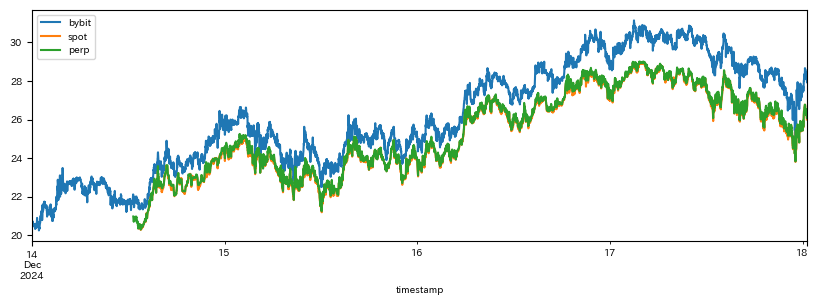

In [96]:
plt.figure(figsize=(10, 3))
tmp = ohlcv_bybit['2024-12-14':]
tmp['bybit_close'].plot(label='bybit')
tmp['hl_spot_close'].plot(label='spot')
tmp['hl_perp_close'].plot(label='perp')
plt.legend();


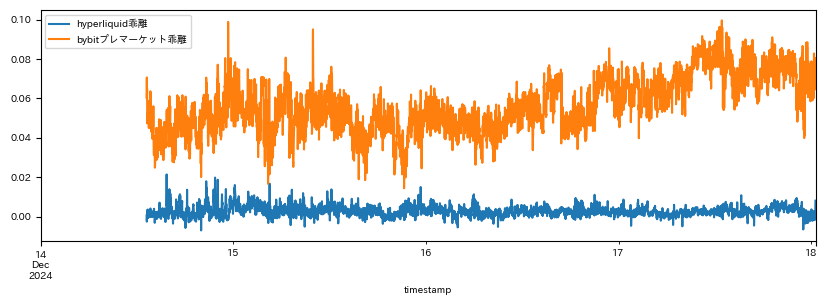

In [198]:
plt.figure(figsize=(10, 3))
tmp = ohlcv_bybit['2024-12-14':]
tmp['hl_dev'].plot(label='hyperliquid乖離')
tmp['bybit_dev'].plot(label='bybitプレマーケット乖離')
plt.legend();

- 標準化してやる

In [111]:
ohlcv_bybit['hl_dev'] = ohlcv_bybit['hl_perp_close'] / ohlcv_bybit['hl_spot_close'] - 1
ohlcv_bybit['bybit_dev_std'] = (ohlcv_bybit['bybit_dev'] - ohlcv_bybit['bybit_dev'].rolling(60).mean()) / ohlcv_bybit['bybit_dev'].rolling(60).std()

# 検証

## bybit価格乖離が価格にもたらす影響

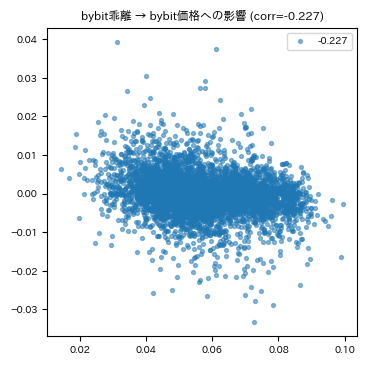

In [110]:
plot_corr(ohlcv_bybit['bybit_dev'].shift(1), ohlcv_bybit['bybit_ror'], title='bybit乖離 → bybit価格への影響')

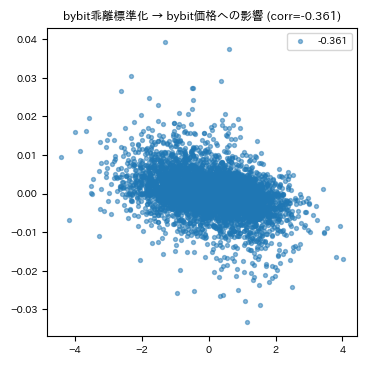

In [113]:
plot_corr(ohlcv_bybit['bybit_dev_std'].shift(1), ohlcv_bybit['bybit_ror'], title='bybit乖離標準化 → bybit価格への影響')

- bybitのプレマーケット価格は、乖離が常態化している。
- それでも、乖離が行き過ぎたら咎めてある程度の水準に戻ってきている。ゆるくペッグはできている模様。

- ハイリキ価格への影響は？

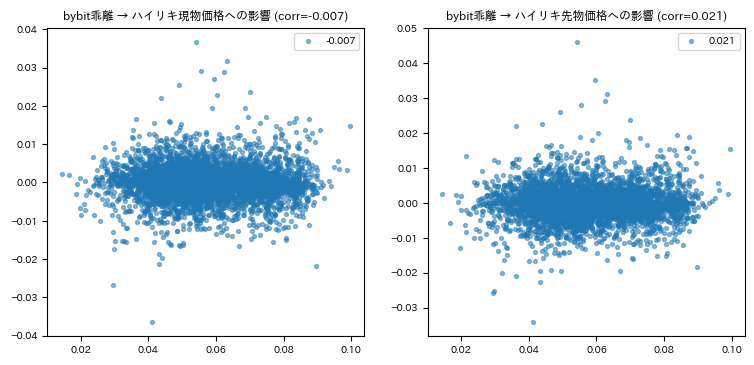

In [109]:
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plot_corr(ohlcv_bybit['bybit_dev'].shift(1), ohlcv_bybit['hl_spot_ror'], title='bybit乖離 → ハイリキ現物価格への影響')
plt.subplot(1, 2, 2)
plot_corr(ohlcv_bybit['bybit_dev'].shift(1), ohlcv_bybit['hl_perp_ror'], title='bybit乖離 → ハイリキ先物価格への影響')

- bybit側の乖離は、ハイリキ価格に与える影響は薄い。

## HyperLiquid先物乖離が価格にもたらす影響

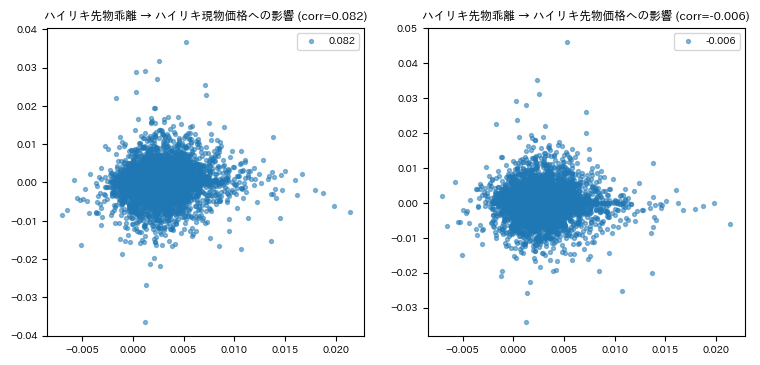

In [108]:
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plot_corr(ohlcv_bybit['hl_dev'].shift(1), ohlcv_bybit['hl_spot_ror'], title='ハイリキ先物乖離 → ハイリキ現物価格への影響')
plt.subplot(1, 2, 2)
plot_corr(ohlcv_bybit['hl_dev'].shift(1), ohlcv_bybit['hl_perp_ror'], title='ハイリキ先物乖離 → ハイリキ先物価格への影響')

- ハイリキの先物乖離はハイリキ現物価格へ若干影響を与えている。
- つまりこの期間（12/14～12/18）で言えば先物が若干主導している。

# 収益機会の考察

## bybitのHYPE/USDTの約定履歴の取得

- 以前の勉強会「15_約定履歴や板の分析の基礎①」で出てきた、bybitの約定履歴の取得方法と同じ。
- csvでDLできるので、読み込みます。

In [114]:
executions = pd.concat([
    pd.read_csv('./data/17_HYPEUSDT2024-12-14.csv'),
    pd.read_csv('./data/17_HYPEUSDT2024-12-15.csv'),
    pd.read_csv('./data/17_HYPEUSDT2024-12-16.csv'),
    pd.read_csv('./data/17_HYPEUSDT2024-12-17.csv'),
], axis=0)
executions.index = pd.to_datetime(executions['timestamp'], unit='s', utc=True)
executions = executions.sort_index()
executions

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,,
2024-12-14 00:00:03.451299906+00:00,1.734134e+09,HYPEUSDT,Buy,0.04,20.620,ZeroPlusTick,8dbde67b-f9b5-5b35-8c68-85f057d201bb,8.248000e+07,0.04,0.82480
2024-12-14 00:00:04.611999989+00:00,1.734134e+09,HYPEUSDT,Buy,0.04,20.620,ZeroPlusTick,7131ceef-d2c5-58b6-93d2-d5338d2aed6f,8.248000e+07,0.04,0.82480
2024-12-14 00:00:06.479899883+00:00,1.734134e+09,HYPEUSDT,Sell,0.04,20.604,MinusTick,2c20289d-a321-50b2-bc7f-8c5550f9b2db,8.241600e+07,0.04,0.82416
2024-12-14 00:00:06.479899883+00:00,1.734134e+09,HYPEUSDT,Sell,0.04,20.604,ZeroMinusTick,3e2293e7-5709-5978-9fac-d9fb489a4733,8.241600e+07,0.04,0.82416
2024-12-14 00:00:06.479899883+00:00,1.734134e+09,HYPEUSDT,Sell,0.04,20.604,ZeroMinusTick,0bbe94f7-c365-529b-ae0e-c5e26c5128a8,8.241600e+07,0.04,0.82416
...,...,...,...,...,...,...,...,...,...,...
2024-12-17 23:59:43.470400095+00:00,1.734480e+09,HYPEUSDT,Sell,10.00,27.650,ZeroMinusTick,08fa1a01-7346-516c-8e2c-094fb5c07556,2.765000e+10,10.00,276.50000
2024-12-17 23:59:43.484800100+00:00,1.734480e+09,HYPEUSDT,Sell,16.56,27.650,ZeroMinusTick,02afd5e9-9b70-5640-803c-4be3a952c51a,4.578840e+10,16.56,457.88400
2024-12-17 23:59:55.294100046+00:00,1.734480e+09,HYPEUSDT,Sell,31.63,27.571,MinusTick,46b0a11f-9bed-5266-855b-2662e50ea768,8.720707e+10,31.63,872.07073


## 適正価格の算出

In [139]:
def plot1(start, end):
    tmp = ohlcv_bybit.copy()
    tmp['center'] = tmp['hl_spot_close'] * (tmp['bybit_dev'].rolling(30).mean() + 1)
    tmp['upper1'] = tmp['hl_spot_close'] * (tmp['bybit_dev'].rolling(30).mean() + 1 + 0.025)
    tmp['lower1'] = tmp['hl_spot_close'] * (tmp['bybit_dev'].rolling(30).mean() + 1 - 0.025)
    tmp = tmp[start:end]
    plt.figure(figsize=(20, 5))
    plt.plot(executions[start:end]['price'], label='executions', color='k', linewidth=0.5)
    plt.plot(tmp['center'], linewidth=0.5, color='red')
    plt.fill_between(tmp.index, tmp['lower1'], tmp['upper1'], color="#0066FF", alpha=0.2)
    plt.legend();

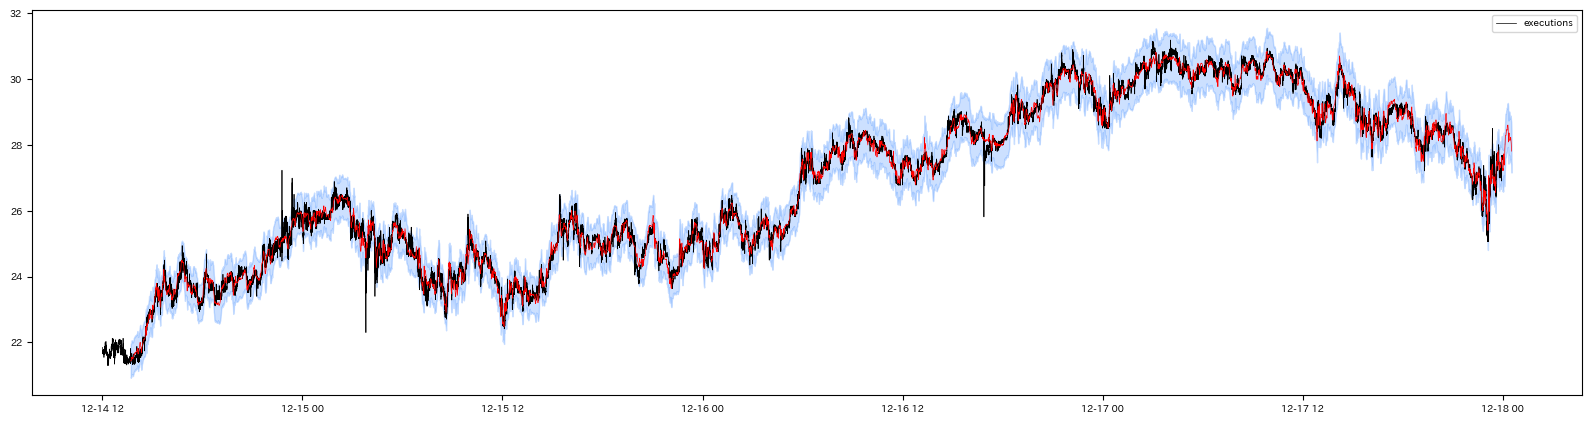

In [140]:
plot1(start='2024-12-14 12', end='2024-12-18')

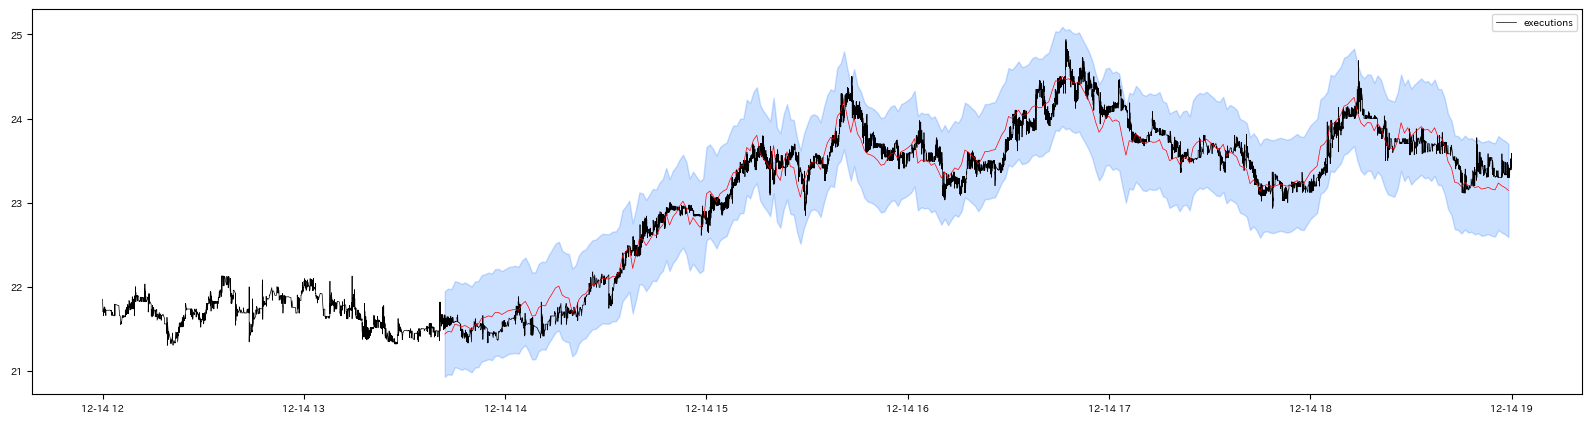

In [141]:
plot1(start='2024-12-14 12', end='2024-12-14 18')

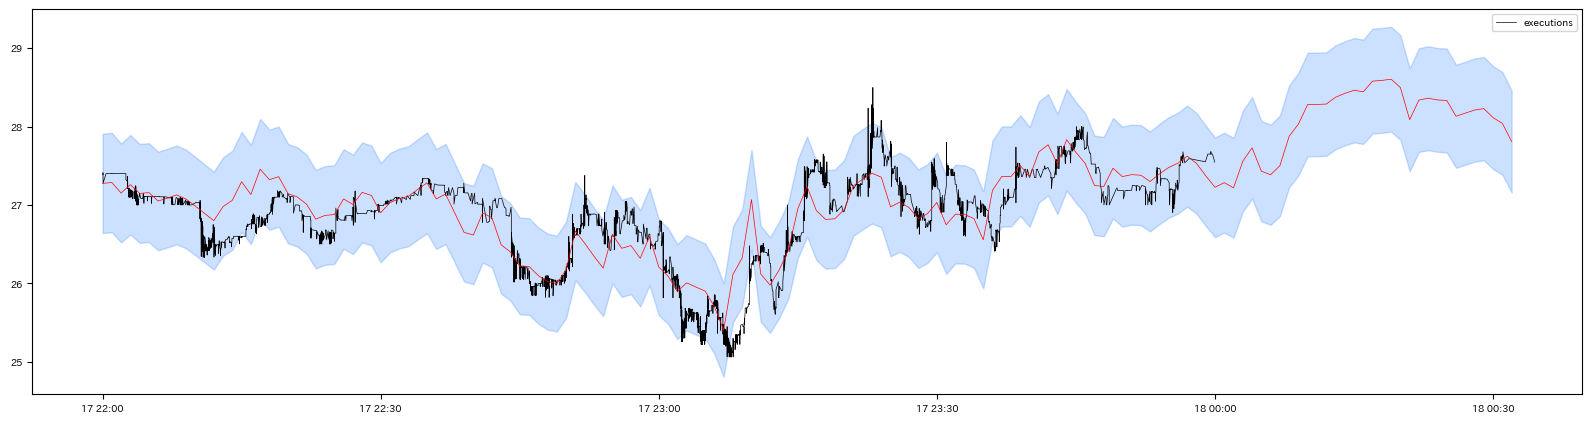

In [142]:
plot1(start='2024-12-17 22', end='2024-12-18 00')

## 収益化できそうか？

- 案1. ヒゲキャッチ
  - 数日に1回レべルのヒゲをキャッチする。比較的安全
- 案2. マーケットメイク
  - マーケットメイクっぽくバンド内で指値を出す。

## Perpetualが上場決定したらどうなる？

- 高い確率で乖離が収束に向かう。現在水準だと6～7%ある乖離がほぼ無くなると考えられる。

- bybitのアナウンスを監視

In [145]:
announces = requests.get('https://api.bybit.com/v5/announcements/index?locale=en-US&limit=500').json()

In [147]:
announces['result']['list'][0]

{'title': 'APT Force Awakens: Earn Points to Win APT Airdrops and Gold Bars',
 'description': 'Step into the APT Force Field and unlock exclusive rewards by completing simple tasks. In this exciting event, you can earn points to redeem APT airdrops and 20g 24K gold bars in the Aptos Points Plaza. ',
 'type': {'title': 'Latest Activities', 'key': 'latest_activities'},
 'tags': ['USDT'],
 'url': 'https://announcements.bybit.com/en-US/article/apt-force-awakens-earn-points-to-win-atp-airdrops-and-gold-bars-blt593a2fee4be85288/',
 'dateTimestamp': 1733306400000,
 'startDateTimestamp': 1733184000000,
 'endDateTimestamp': 1734948000000,
 'publishTime': 1733825028000}

- New Listingの場合、以下のようなメッセージとなる。
  - type title: New Listings
  - title: New Listing: Bybit is supporting 5 new USDC Perpetual Contract
  - description: Bybit has listed DOT-PERP, LINK-PERP, XLM-PERP, ENA-PERP, BONK-PERP USDC Perpetual Contract with up to 50x leverage.

- 定期的にこのAccouncement APIをリクエストして、HYPE-PERPのNew Listingがあればハイリキ側でロング＆bybit側でショート、もしくはbybitで裸ショートする。
- マーケットメイク、ヒゲ取りボットを動かしている際、
  - ロングポジションを持っていたら即決済する、
  - あるいは最初からロング側を持たない。必ずショートから入るようにする

# まとめ「で、本当に収益化できるの？」

- 暇があったらやってみて報告します。
- 興味ある人は、やってみてね！手を動かすとレベルアップにつながります。

# 追記

- 12/19 20時（日本時間）にPerpetualが上場（UTCだと12/19 11時）
- bybit公式のXでのアナウンスは、20時の上場タイミングと同時

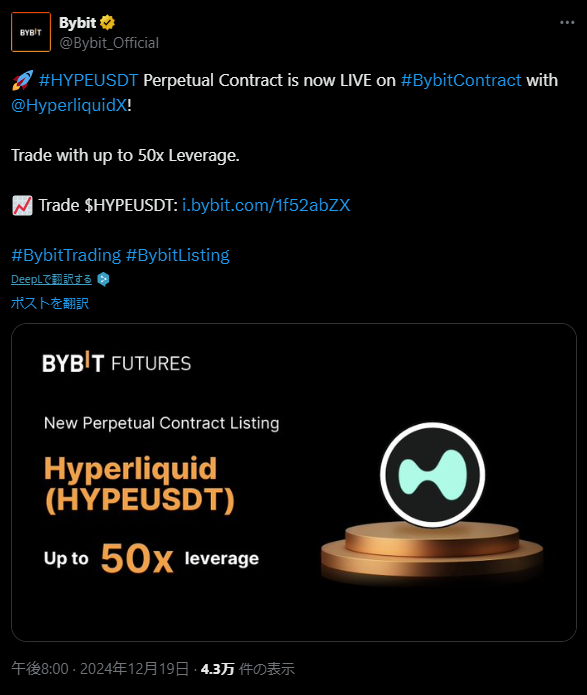

In [148]:
Image('./images/17_04.png')

- 乖離縮小の様子を確認する

In [184]:
ohlcv_bybit2 = fetch_ohlcv('bybit', 'HYPE/USDT:USDT', from_date='2024-12-19 00:00:00', to_date='2024-12-19 16:00:00', timeframe='1m')
ohlcv_hl_spot2 = fetch_ohlcv('hyperliquid', 'HYPE/USDC', from_date='2024-12-19 00:00:00', to_date='2024-12-19 16:00:00', timeframe='1m')
for column in ohlcv_hl_spot2.columns:
    ohlcv_bybit2[column.replace('hyperliquid', 'hl_spot')] = ohlcv_hl_spot2[column]

# 乖離計算
ohlcv_bybit2['bybit_dev'] = ohlcv_bybit2['bybit_close'] / ohlcv_bybit2['hl_spot_close'] - 1

- UTCで9時過ぎごろに乖離が一気に埋まっている様子が分かる。

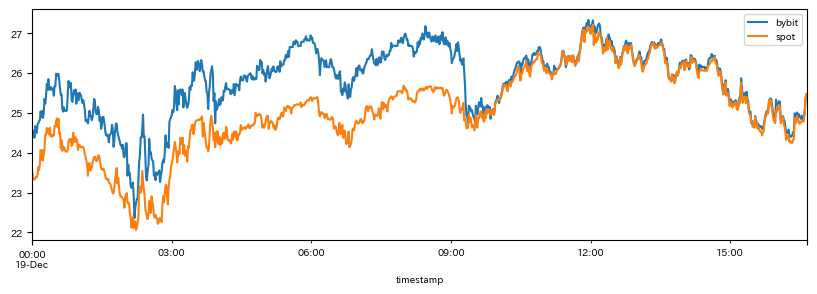

In [185]:
plt.figure(figsize=(10, 3))
tmp = ohlcv_bybit2
tmp['bybit_close'].plot(label='bybit')
tmp['hl_spot_close'].plot(label='spot')
plt.legend();

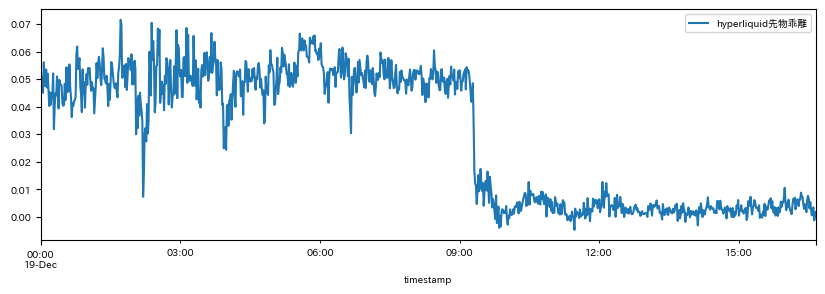

In [186]:
plt.figure(figsize=(10, 3))
tmp = ohlcv_bybit2
tmp['bybit_dev'].plot(label='hyperliquid先物乖離')
plt.legend();

- このタイミングで公式からアナウンスがあったのか？

In [187]:
announces2 = requests.get('https://api.bybit.com/v5/announcements/index?locale=en-US&limit=100').json()

In [192]:
for announce in announces2['result']['list']:
    if announce['type']['title'] == 'New Listings' and 'HYPE' in announce['title']:
        print(f'- PublishTime        : {datetime.fromtimestamp(announce["publishTime"] / 1000)}')
        print(f'- dateTimestamp      : {datetime.fromtimestamp(announce["dateTimestamp"] / 1000)}')
        print(f'- startDateTimestamp : {datetime.fromtimestamp(announce["startDateTimestamp"] / 1000)}')
        print(f'- endDateTimestamp   : {datetime.fromtimestamp(announce["endDateTimestamp"] / 1000)}')
        print(f'- Title              : {announce["title"]}')
        

- PublishTime        : 2024-12-19 09:38:56
- dateTimestamp      : 2024-12-19 09:37:30
- startDateTimestamp : 2024-12-19 09:37:30
- endDateTimestamp   : 2024-12-19 09:37:30
- Title              : Converting HYPEUSDT Perpetual Pre-Market Trading to Standard Perpetual Contract on Bybit Derivatives


- Announcement APIの内容は、9:37となっている。

- 詳細を見ると、その20分前の9:17ごろから乖離が埋まっている。
- このタイミングでアナウンスされたのか、あるいはインサイダー的なやつなのかは不明。
- やはり上場タイミングで乖離が埋まったが、狙っていた人が収益化できたかどうかは不明。

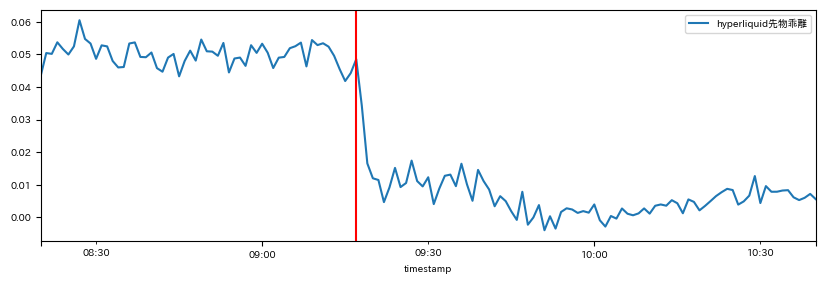

In [197]:
plt.figure(figsize=(10, 3))
tmp = ohlcv_bybit2['2024-12-19 08:20:00':'2024-12-19 10:40:00']
tmp['bybit_dev'].plot(label='hyperliquid先物乖離')
plt.axvline(pd.to_datetime('2024-12-19 09:17:00'), color='red')
plt.legend();